### This notebook generates spinless BBH waveform template as in Heurta's paper

* All waveform is saved in a single HDF5 file, with filename defined as HDF5_FILE
* For testing purpose and reducing the file size, only Hplus component of waveform with smaller sampling rate are generated. I also generate a coarser template bank with delta_M = 2 (Heurta use 1)


/home/lincy/.local/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters



('Numbers of waveforms : ', 292)


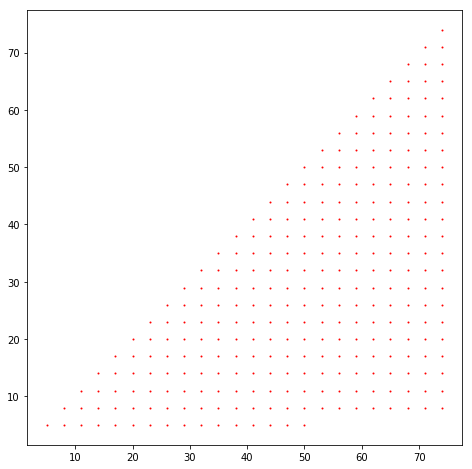

In [1]:
##
##  First, let'e make a (m1,m2) parameter table for the template
##

import pycbc
from pycbc.waveform import td_approximants, fd_approximants, get_td_waveform
import matplotlib.pyplot as plt
%matplotlib inline
import itertools

#### 
MINM=5
MAXM=75
dM=3
m1a = []
m2a = []
for m1 in range(MINM, MAXM+1, dM):     
    for m2 in range(m1, MAXM+1, dM):    ###  m2>=m1
        if (float(m2)/m1<=10):
            m1a.append(m1)
            m2a.append(m2)

print ("Numbers of waveforms : ", len(m1a))            
plt.figure(figsize=(8,8))
plt.plot(m2a, m1a, 'r.', markersize=2)
plt.axes().set_aspect('equal')
plt.show()

In [2]:
##
##  This function tell you all TD / FD waveform model supported in pyCBC.
##  We will use SEOBNRv4
##

import pycbc
print "== TD ================"
print pycbc.waveform.td_approximants()
print "== FD ================"
print pycbc.waveform.fd_approximants()


== TD ================
['TEOBResum_ROM', 'TaylorEt', 'SEOBNRv3_opt', 'IMRPhenomA', 'IMRPhenomC', 'IMRPhenomB', 'EOBNRv2', 'NRSur7dq2', 'TEOBv4', 'SEOBNRv4_opt', 'PhenSpinTaylor', 'PhenSpinTaylorRD', 'NR_hdf5', 'TEOBv2', 'SEOBNRv3_pert', 'EOBNRv2HM', 'SpinTaylorT4', 'TaylorT1', 'TaylorT3', 'TaylorT2', 'HGimri', 'TaylorT4', 'IMRPhenomD', 'IMRPhenomPv2', 'SEOBNRv1', 'SpinDominatedWf', 'SEOBNRv3', 'SEOBNRv2', 'SpinTaylorT1', 'SEOBNRv4', 'SpinTaylorT2', 'EccentricTD', 'SEOBNRv2_opt', 'SEOBNRv3_opt_rk4']
== FD ================
['IMRPhenomD_NRTidal', 'TaylorF2', 'SEOBNRv2_ROM_EffectiveSpin', 'IMRPhenomA', 'IMRPhenomC', 'IMRPhenomB', 'IMRPhenomD', 'SpinTaylorT2Fourier', 'IMRPhenomPv2_INTERP', 'SpinTaylorT4Fourier', 'TaylorF2NLTides', 'IMRPhenomD_INTERP', 'SEOBNRv2_ROM_DoubleSpin', 'IMRPhenomP', 'SEOBNRv4_ROM_NRTidal', 'SpinTaylorF2', 'SEOBNRv2_ROM_DoubleSpin_INTERP', 'SEOBNRv1_ROM_DoubleSpin_INTERP', 'EOBNRv2_ROM_INTERP', 'TaylorF2_INTERP', 'SEOBNRv2_ROM_DoubleSpin_HI', 'SpinTaylorF2_INTERP', 

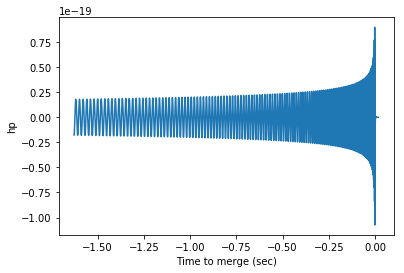

In [3]:
###
###  For you yo get a feeling about the waveform, here m=(5,5) waveform is plotted.
###

import pycbc.psd

import matplotlib.pyplot as plt
%matplotlib inline

import itertools

RATE = 4096  #8192
apx='SEOBNRv4'
#for m1,m2 in itertools.izip(m1a,m2a):

for m1,m2 in itertools.izip([5],[5]):
    hp, hc = pycbc.waveform.get_td_waveform(approximant=apx,
             mass1=m1, mass2=m2, spin1z=0, delta_t=1.0/RATE, f_lower=50.0)

    plt.plot(hp.sample_times, hp, label=apx)
    plt.xlabel("Time to merge (sec)")
    plt.ylabel("hp")


In [4]:
"""
Estimate low freq at the 'time to merger'
Ref: Eq.8 in 1608.01940
"""
import numpy as np

GM0 = 6.674e-11 * 1.9891e30
c   = 299792458.
C1=5**(3/8.)/(8*np.pi) * ((c**3)/GM0)**(5./8) 

def time2lowfreq(m1,m2,t):
    Mcf= (m1*m2)**(-0.375) * (m1+m2)**(0.125)
    freq = C1 * Mcf * (t*1.25)**(-0.375)    ## here I add factor 1.25 just to get a longer waveform
    
    return freq 
    

In [5]:
##
##  Write to HDF5
##
import pycbc.psd
import matplotlib.pyplot as plt
%matplotlib inline
import itertools
import h5py

###
HDF5_FILE = 'bbh_wftpl.h5'
RATE      = 4096  # sampling rate 
FLOW      = 40    # lower cutoff frequency
apx       = 'SEOBNRv4'

f = h5py.File(HDF5_FILE, 'w', libver='latest')

###
main_grp = f.create_group("/waveform")
main_grp.attrs['srate'] = RATE
main_grp.attrs['model'] = apx
main_grp.attrs['desc'] = "Spinless BBH waveform model"

###
count = 0
dt = 1.0/RATE
for m1,m2 in itertools.izip(m1a,m2a):

    f_low = time2lowfreq(m1,m2,2.0)
    
    hp, hc = pycbc.waveform.get_td_waveform(approximant=apx,
        mass1=m1, mass2=m2, spin1z=0, delta_t=dt, f_lower=f_low)

    gname = "%s" % count    
    print ("Waveform #%s with mass %.1f, %.1f, f_low = %.1f, t0 = %.1f (#pts %d)..." 
           % (gname, m1, m2, f_low, hp.sample_times[0], len(hp.sample_times) ))
    
    grp = main_grp.create_group(gname)
    grp.attrs['m'] = [m1,m2]
    grp.attrs['sz'] = [0,0]
    grp.attrs['F_low'] = f_low
    grp.create_dataset("t2m",  data=hp.sample_times, dtype='f')  # compression='gzip'
    grp.create_dataset("hp",  data=hp, dtype='f') #, compression='gzip'
    #grp.create_dataset("hc",  data=hc, dtype='f') #, compression='gzip'

    count = count+1
    #if (count > 4):         break
        
print ("Done.")
f.close()

Waveform #0 with mass 5.0, 5.0, f_low = 42.7, t0 = -2.5 (#pts 10316)...
Waveform #1 with mass 5.0, 8.0, f_low = 37.0, t0 = -2.5 (#pts 10245)...
Waveform #2 with mass 5.0, 11.0, f_low = 33.7, t0 = -2.4 (#pts 10138)...
Waveform #3 with mass 5.0, 14.0, f_low = 31.5, t0 = -2.4 (#pts 10016)...
Waveform #4 with mass 5.0, 17.0, f_low = 29.8, t0 = -2.4 (#pts 9889)...
Waveform #5 with mass 5.0, 20.0, f_low = 28.5, t0 = -2.3 (#pts 9759)...
Waveform #6 with mass 5.0, 23.0, f_low = 27.4, t0 = -2.3 (#pts 9627)...
Waveform #7 with mass 5.0, 26.0, f_low = 26.5, t0 = -2.3 (#pts 9495)...
Waveform #8 with mass 5.0, 29.0, f_low = 25.7, t0 = -2.2 (#pts 9362)...
Waveform #9 with mass 5.0, 32.0, f_low = 25.1, t0 = -2.2 (#pts 9230)...
Waveform #10 with mass 5.0, 35.0, f_low = 24.5, t0 = -2.1 (#pts 9099)...
Waveform #11 with mass 5.0, 38.0, f_low = 24.0, t0 = -2.1 (#pts 8968)...
Waveform #12 with mass 5.0, 41.0, f_low = 23.5, t0 = -2.1 (#pts 8837)...
Waveform #13 with mass 5.0, 44.0, f_low = 23.0, t0 = -2.0 (

Waveform #111 with mass 20.0, 47.0, f_low = 13.9, t0 = -2.3 (#pts 9857)...
Waveform #112 with mass 20.0, 50.0, f_low = 13.7, t0 = -2.3 (#pts 9813)...
Waveform #113 with mass 20.0, 53.0, f_low = 13.4, t0 = -2.2 (#pts 9767)...
Waveform #114 with mass 20.0, 56.0, f_low = 13.2, t0 = -2.2 (#pts 9721)...
Waveform #115 with mass 20.0, 59.0, f_low = 13.0, t0 = -2.2 (#pts 9675)...
Waveform #116 with mass 20.0, 62.0, f_low = 12.9, t0 = -2.2 (#pts 9627)...
Waveform #117 with mass 20.0, 65.0, f_low = 12.7, t0 = -2.2 (#pts 9580)...
Waveform #118 with mass 20.0, 68.0, f_low = 12.5, t0 = -2.2 (#pts 9532)...
Waveform #119 with mass 20.0, 71.0, f_low = 12.4, t0 = -2.1 (#pts 9484)...
Waveform #120 with mass 20.0, 74.0, f_low = 12.2, t0 = -2.1 (#pts 9436)...
Waveform #121 with mass 23.0, 23.0, f_low = 16.5, t0 = -2.4 (#pts 10143)...
Waveform #122 with mass 23.0, 26.0, f_low = 15.8, t0 = -2.4 (#pts 10134)...
Waveform #123 with mass 23.0, 29.0, f_low = 15.3, t0 = -2.4 (#pts 10117)...
Waveform #124 with mas

Waveform #220 with mass 41.0, 59.0, f_low = 10.3, t0 = -2.3 (#pts 10107)...
Waveform #221 with mass 41.0, 62.0, f_low = 10.1, t0 = -2.3 (#pts 10094)...
Waveform #222 with mass 41.0, 65.0, f_low = 10.0, t0 = -2.3 (#pts 10080)...
Waveform #223 with mass 41.0, 68.0, f_low = 9.8, t0 = -2.3 (#pts 10064)...
Waveform #224 with mass 41.0, 71.0, f_low = 9.7, t0 = -2.2 (#pts 10048)...
Waveform #225 with mass 41.0, 74.0, f_low = 9.6, t0 = -2.2 (#pts 10031)...
Waveform #226 with mass 44.0, 44.0, f_low = 11.0, t0 = -2.3 (#pts 10150)...
Waveform #227 with mass 44.0, 47.0, f_low = 10.7, t0 = -2.3 (#pts 10152)...
Waveform #228 with mass 44.0, 50.0, f_low = 10.5, t0 = -2.3 (#pts 10151)...
Waveform #229 with mass 44.0, 53.0, f_low = 10.4, t0 = -2.3 (#pts 10147)...
Waveform #230 with mass 44.0, 56.0, f_low = 10.2, t0 = -2.3 (#pts 10142)...
Waveform #231 with mass 44.0, 59.0, f_low = 10.0, t0 = -2.3 (#pts 10134)...
Waveform #232 with mass 44.0, 62.0, f_low = 9.9, t0 = -2.3 (#pts 10124)...
Waveform #233 wi

In [6]:
###
###  List the structure of this HDF5 file
###

def printname(name):
    print name
def print_attrs(name, obj):
    print (name)
    for key, val in obj.attrs.iteritems():
        print ("    %s: %s" % (key, val))
    
f = h5py.File(HDF5_FILE,'r')
#print (f.attrs.items())
#f.visit(printname)
f.visititems(print_attrs)
f.close()  

waveform
    srate: 4096
    model: SEOBNRv4
    desc: Spinless BBH waveform model
waveform/241
    m: [47 59]
    sz: [0 0]
    F_low: 9.813873969202461
waveform/241/t2m
waveform/241/hp
waveform/275
    m: [59 71]
    sz: [0 0]
    F_low: 8.62452088612002
waveform/275/t2m
waveform/275/hp
waveform/87
    m: [17 32]
    sz: [0 0]
    F_low: 16.413770886331235
waveform/87/t2m
waveform/87/hp
waveform/0
    m: [5 5]
    sz: [0 0]
    F_low: 42.71259336298938
waveform/0/t2m
waveform/0/hp
waveform/245
    m: [47 71]
    sz: [0 0]
    F_low: 9.279191076459698
waveform/245/t2m
waveform/245/hp
waveform/272
    m: [59 62]
    sz: [0 0]
    F_low: 8.993220208873145
waveform/272/t2m
waveform/272/hp
waveform/71
    m: [14 44]
    sz: [0 0]
    F_low: 15.999970299880014
waveform/71/t2m
waveform/71/hp
waveform/45
    m: [11 29]
    F_low: 19.548770006962684
    sz: [0 0]
waveform/45/t2m
waveform/45/hp
waveform/252
    m: [50 65]
    sz: [0 0]
    F_low: 9.34145259077995
waveform/252/t2m
waveform/252/

waveform/217/hp
waveform/226
    m: [44 44]
    sz: [0 0]
    F_low: 10.971203508704903
waveform/226/t2m
waveform/226/hp
waveform/80
    m: [14 71]
    sz: [0 0]
    F_low: 14.02622870193347
waveform/80/t2m
waveform/80/hp
waveform/215
    m: [41 44]
    sz: [0 0]
    F_low: 11.216880939491107
waveform/215/t2m
waveform/215/hp
waveform/218
    m: [41 53]
    sz: [0 0]
    F_low: 10.593196507910642
waveform/218/t2m
waveform/218/hp
waveform/289
    m: [71 71]
    sz: [0 0]
    F_low: 8.13534033269208
waveform/289/hp
waveform/289/t2m
waveform/271
    m: [59 59]
    sz: [0 0]
    F_low: 9.133341292035153
waveform/271/t2m
waveform/271/hp
waveform/158
    m: [29 35]
    sz: [0 0]
    F_low: 13.431705940856478
waveform/158/t2m
waveform/158/hp
waveform/68
    m: [14 35]
    sz: [0 0]
    F_low: 17.07003550189097
waveform/68/t2m
waveform/68/hp
waveform/177
    m: [32 47]
    sz: [0 0]
    F_low: 11.899230906875102
waveform/177/t2m
waveform/177/hp
waveform/211
    m: [38 68]
    sz: [0 0]
    F_lo

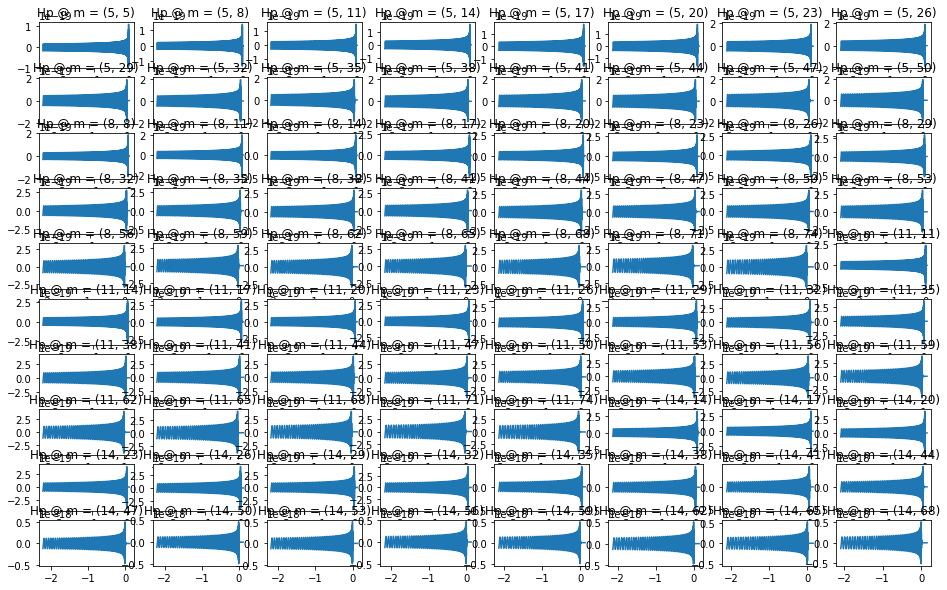

In [12]:
###
###  Read waveform from HDF5, and plot it. 
###

f = h5py.File(HDF5_FILE,'r')

plt.figure(figsize=(16,10))
for i in range(len(m1a)):
    
    plt.subplot(10,8,i+1)
    key = 'waveform/%d'%i
    k1  = 'waveform/%d/t2m'%i
    k2  = 'waveform/%d/hp'%i
    
    m1 = f[key].attrs['m'][0]
    m2 = f[key].attrs['m'][1]
    t2m = f[k1][:]
    hp  = f[k2][:]

    plt.plot(t2m, hp)
    plt.title("Hp @ m = (%d, %d)" % (m1,m2) )
    
    if (i > 78): break
    
f.close()  

In [8]:
###
###  TODO:  load detector noise PSD to 'de-whiten' the waveform 
###